# 01. Exploratory Data Analysis (EDA)

## Goal
- Load the Lending Club dataset.
- Split data by time (Train: 2014-2016, Test/Shift: 2018-2019).
- Analyze default rates, feature distributions, and missing values.
- visualizes the shift between the two periods.

In [12]:
# Install dependencies if running in Colab/Fresh Environment
!pip install pandas numpy matplotlib seaborn kaggle

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline

print("Setup Complete.")

Setup Complete.


In [14]:
# --- DATA & DRIVE CONFIGURATION ---
import os
import json
import glob

# 1. Setup Colab & Drive
try:
    from google.colab import drive
    print("Mounting Google Drive...")
    drive.mount('/content/drive')
    
    # Create a persistent folder for this project
    # We will SAVE processed files and plots here so they persist
    PROJECT_DIR = '/content/drive/MyDrive/credit_risk_project'
    if not os.path.exists(PROJECT_DIR):
        os.makedirs(PROJECT_DIR)
        print(f"Created {PROJECT_DIR}")
    
    # Create subdirs
    for subdir in ['data/processed', 'results/figures', 'results/tables', 'results/models', 'notebooks']:
        os.makedirs(os.path.join(PROJECT_DIR, subdir), exist_ok=True)
        
    print(f"Project Directory set to: {PROJECT_DIR}")
    
except ImportError:
    # Local fallback (if you run this locally later)
    PROJECT_DIR = '..'
    print("Running locally.")

# 2. Download Data to /content (Fast Ephemeral Storage)
# We don't want to save raw CSV to Drive (slow IO/Upload), just the processed pickles.
RAW_DATA_DIR = '/content'
csv_files = glob.glob(os.path.join(RAW_DATA_DIR, '*.csv'))

DATA_PATH = None
# Look for the specific file or any large CSV that looks like our dataset
for f in csv_files:
    if 'accepted' in f and '2007' in f:
        # Check if it's a file, not a directory
        if os.path.isfile(f):
            DATA_PATH = f
            break

if DATA_PATH and os.path.isfile(DATA_PATH):
    print(f"Found data at {DATA_PATH}")
else:
    print("Data not found (or is a directory). Downloading/Searching...")
    
    # Auto-configure Kaggle Credentials
    kaggle_dir = os.path.expanduser("~/.kaggle")
    if not os.path.exists(kaggle_dir):
        os.makedirs(kaggle_dir)
    
    kaggle_json_path = os.path.join(kaggle_dir, "kaggle.json")
    if not os.path.exists(kaggle_json_path):
        with open(kaggle_json_path, 'w') as f:
            json.dump({"username": "siddarthakarri", "key": "10d1a8fad01dd50dd2916f581527d685"}, f)
        os.chmod(kaggle_json_path, 0o600)
    
    # Download to /content if not present
    # We skip usage of ! if it's already there to avoid re-download
    if not DATA_PATH:
        print("Downloading from Kaggle...")
        !kaggle datasets download -d wordsforthewise/lending-club -p {RAW_DATA_DIR} --unzip
    
    # Find file again - Robust check
    DATA_PATH = None
    # Walk to find the actual CSV file, bypassing any excessive directory nesting
    for root, dirs, files in os.walk(RAW_DATA_DIR):
        for file in files:
            if 'accepted' in file and file.endswith('.csv') and not file.startswith('.'):
                 potential_path = os.path.join(root, file)
                 # Double check size to ensure it's the big data file, not a small test file if any
                 if os.path.getsize(potential_path) > 1000000: # > 1MB
                    DATA_PATH = potential_path
                    break
        if DATA_PATH:
            break
            
    if DATA_PATH and os.path.isfile(DATA_PATH):
        print(f"File Found: {DATA_PATH}")
    else:
        print("Error: Could not find the csv file. Please check files in the file explorer on the left.")

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Project Directory set to: /content/drive/MyDrive/credit_risk_project
Data not found (or is a directory). Downloading/Searching...
Dataset URL: https://www.kaggle.com/datasets/wordsforthewise/lending-club
License(s): CC0-1.0
 97% 1.22G/1.26G [00:09<00:00, 147MB/s] 
100% 1.26G/1.26G [00:09<00:00, 139MB/s]
File Found: /content/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv


In [15]:
# DEFINE COLUMNS TO LOAD (To save RAM if needed, though Colab usually has 12GB+)
# Loading all columns can be memory intensive. We select the most relevant ones for Credit Risk.

cols = [
    'id', 'loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
    'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
    'issue_d', 'loan_status', 'purpose', 'title', 'zip_code', 'addr_state',
    'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high',
    'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
    'initial_list_status', 'application_type', 'pub_rec_bankruptcies', 'mort_acc'
]

# Load Data
print("Loading data...")
# Note: low_memory=False avoids warning about mixed types, but uses more RAM.
# If low RAM env, maybe verify usecols first
if DATA_PATH:
    df = pd.read_csv(DATA_PATH, usecols=cols, low_memory=False)
    print(f"Original Data Shape: {df.shape}")
else:
    print("Skipping load data - Path not found")

Loading data...
Original Data Shape: (2260701, 32)


In [16]:
# --- PREPROCESSING & SPLITTING ---

# 1. Filter for valid Target Labels
# We strictly only want 'Fully Paid' and 'Charged Off' for this binary classification task.
valid_status = ['Fully Paid', 'Charged Off', 'Default']
df = df[df['loan_status'].isin(valid_status)].copy()

# Merge 'Default' into 'Charged Off' (Standard practice)
df['loan_status'] = df['loan_status'].replace('Default', 'Charged Off')

# Encode Target: 0 = Good (Fully Paid), 1 = Bad (Charged Off)
df['target'] = df['loan_status'].apply(lambda x: 1 if x == 'Charged Off' else 0)

print(f"Filtered Data Shape: {df.shape}")
print(f"Overall Default Rate: {df['target'].mean():.4f}")

Filtered Data Shape: (1345350, 33)
Overall Default Rate: 0.1996


In [17]:
# 2. Convert Dates
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y')

# 3. Time Split
# Dataset A (Train/Val): 2014 - 2016
# Dataset B (OOD/Test): 2018 - 2019

train_start = '2014-01-01'
train_end = '2016-12-31'
ood_start = '2018-01-01'
ood_end = '2019-12-31'

train_mask = (df['issue_d'] >= train_start) & (df['issue_d'] <= train_end)
ood_mask = (df['issue_d'] >= ood_start) & (df['issue_d'] <= ood_end)

df_train = df[train_mask].copy()
df_ood = df[ood_mask].copy()

print(f"Dataset A (Train/In-Distribution 2014-16): {df_train.shape}")
print(f"Dataset B (Shift/Out-of-Distribution 2018-19): {df_ood.shape}")

Dataset A (Train/In-Distribution 2014-16): (891754, 33)
Dataset B (Shift/Out-of-Distribution 2018-19): (56318, 33)


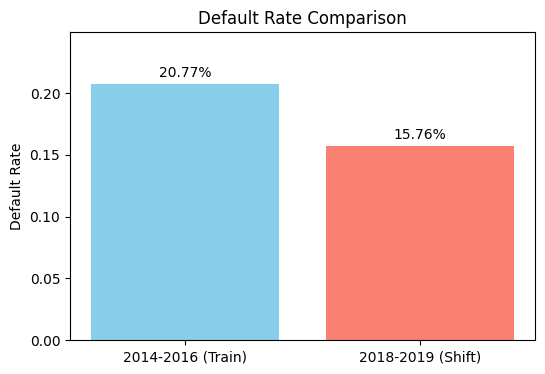

In [18]:
# --- EDA: VISUALIZING DISTRIBUTION SHIFT ---

# 1. Default Rate Comparison
default_rates = [
    df_train['target'].mean(),
    df_ood['target'].mean()
]

plt.figure(figsize=(6, 4))
plt.bar(['2014-2016 (Train)', '2018-2019 (Shift)'], default_rates, color=['skyblue', 'salmon'])
plt.title('Default Rate Comparison')
plt.ylabel('Default Rate')
for i, v in enumerate(default_rates):
    plt.text(i, v + 0.005, f"{v:.2%}", ha='center')
plt.ylim(0, max(default_rates) * 1.2)
# SAVE TO DRIVE
plt.savefig(os.path.join(PROJECT_DIR, 'results/figures', 'target_distribution.png'))
plt.show()

/tmp/ipython-input-3682636149.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_train['fico_range_low'], label='2014-2016', shade=True, color='skyblue')
/tmp/ipython-input-3682636149.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_ood['fico_range_low'], label='2018-2019', shade=True, color='salmon')


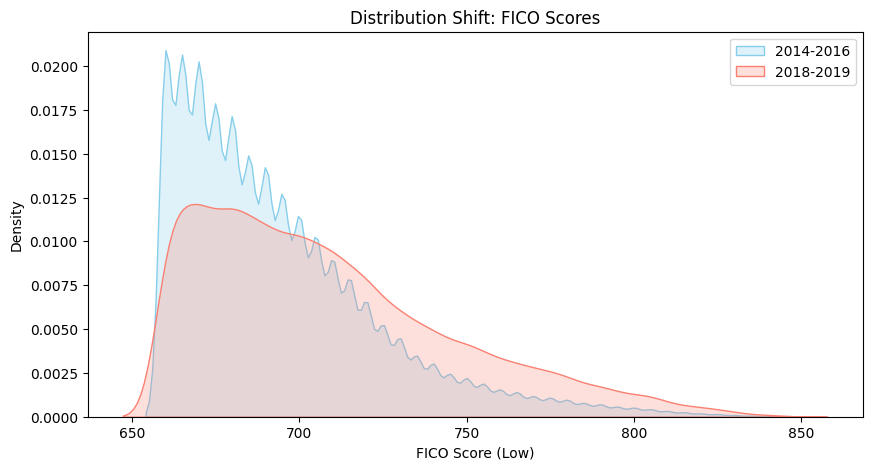

In [19]:
# 2. FICO Score Shift
plt.figure(figsize=(10, 5))
sns.kdeplot(df_train['fico_range_low'], label='2014-2016', shade=True, color='skyblue')
sns.kdeplot(df_ood['fico_range_low'], label='2018-2019', shade=True, color='salmon')
plt.title('Distribution Shift: FICO Scores')
plt.xlabel('FICO Score (Low)')
plt.legend()
# SAVE TO DRIVE
plt.savefig(os.path.join(PROJECT_DIR, 'results/figures', 'fico_shift.png'))
plt.show()

/tmp/ipython-input-2110799335.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_train['int_rate'], label='2014-2016', shade=True, color='skyblue')
/tmp/ipython-input-2110799335.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_ood['int_rate'], label='2018-2019', shade=True, color='salmon')


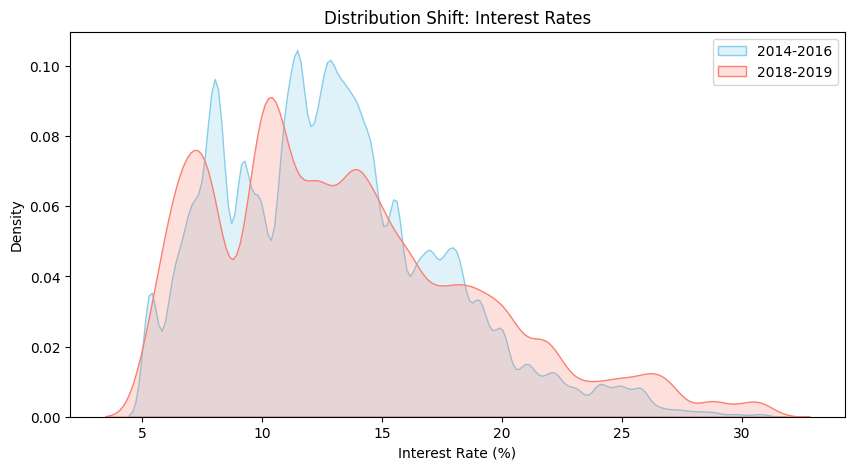

In [20]:
# 3. Interest Rate Shift
plt.figure(figsize=(10, 5))
sns.kdeplot(df_train['int_rate'], label='2014-2016', shade=True, color='skyblue')
sns.kdeplot(df_ood['int_rate'], label='2018-2019', shade=True, color='salmon')
plt.title('Distribution Shift: Interest Rates')
plt.xlabel('Interest Rate (%)')
plt.legend()
# SAVE TO DRIVE
plt.savefig(os.path.join(PROJECT_DIR, 'results/figures', 'int_rate_shift.png'))
plt.show()

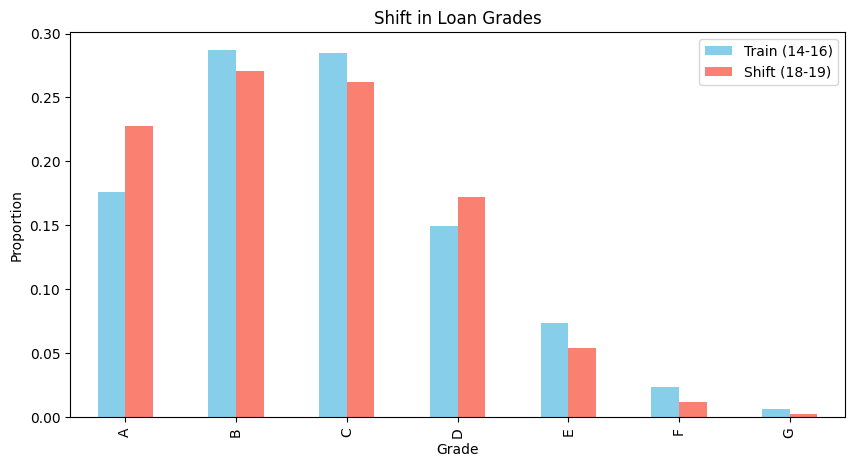

In [21]:
# 4. Loan Grade Distribution comparison
def get_grade_dist(df):
    return df['grade'].value_counts(normalize=True).sort_index()

dist_train = get_grade_dist(df_train)
dist_ood = get_grade_dist(df_ood)

df_grade = pd.DataFrame({'Train (14-16)': dist_train, 'Shift (18-19)': dist_ood})

df_grade.plot(kind='bar', figsize=(10, 5), color=['skyblue', 'salmon'])
plt.title('Shift in Loan Grades')
plt.ylabel('Proportion')
plt.xlabel('Grade')
# SAVE TO DRIVE
plt.savefig(os.path.join(PROJECT_DIR, 'results/figures', 'grade_shift.png'))
plt.show()

In [22]:
# Save processed datasets to Google Drive (Persistent Storage)
# This is CRITICAL. Next notebooks will load from here.

SAVE_DIR = os.path.join(PROJECT_DIR, 'data/processed')
print(f"Saving processed chunks to {SAVE_DIR}...")

if 'id' not in df_train.columns:
    # id might be useful to track loans, but not strictly needed for modeling if dropped
    pass

df_train.to_pickle(os.path.join(SAVE_DIR, 'train_2014_2016.pkl'))
df_ood.to_pickle(os.path.join(SAVE_DIR, 'ood_2018_2019.pkl'))

print(f"Saved processed data successfully.")
print("DONE")

Saving processed chunks to /content/drive/MyDrive/credit_risk_project/data/processed...
Saved processed data successfully.
DONE
